<a href="https://colab.research.google.com/github/dariashcherbakovaaa/Algorithms-for-massive-data/blob/main/MBA_Shcherbakova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Basket Analysis on LinkedIn job skills and job links

###### **Daria Shcherbakova** *(DSE student, 17487A)*

## Settings

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName('Algo_Aprori').getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark
import pyspark
type(spark)

sc = spark.sparkContext
spark

In [2]:
os.environ['KAGGLE_USERNAME'] = 'dariashcherbakovaa'
os.environ['KAGGLE_KEY'] = 'b548e6d99396ffac6cb1a36b2cdb29fb'

In [ ]:
# os.environ['KAGGLE_USERNAME'] = "xxxxxx"
# os.environ['KAGGLE_KEY'] = "xxxxxx"

In [9]:
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024
!unzip 1-3m-linkedin-jobs-and-skills-2024.zip -d job_skills

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
100% 1.88G/1.88G [00:22<00:00, 41.8MB/s]
100% 1.88G/1.88G [00:22<00:00, 87.9MB/s]
Archive:  1-3m-linkedin-jobs-and-skills-2024.zip
  inflating: job_skills/job_skills.csv  
  inflating: job_skills/job_summary.csv  
  inflating: job_skills/linkedin_job_postings.csv  


In [10]:
data_path = '/content/job_skills/job_skills.csv'
df_skills = spark.read.csv(data_path, inferSchema=True, header=True)
df_skills.printSchema()
df_skills.show()

root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)

+--------------------+--------------------+
|            job_link|          job_skills|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
|https://www.linke...|Applied Behavior ...|
|https://www.linke...|Electrical Engine...|
|https://www.linke...|Electrical Assemb...|
|https://www.linke...|Access Control, V...|
|https://www.linke...|Consultation, Sup...|
|https://www.linke...|Veterinary Recept...|
|https://www.linke...|Optical Inspectio...|
|https://www.linke...|HVAC, troubleshoo...|
|https://www.linke...|Host/Server Assis...|
|https://www.linke...|Apartment mainten...|
|https://www.linke...|Fiber Optic Cable...|
|https://www.linke...|CT Technologist, ...|
|https://ca.linked...|SAP, DRMIS, Data ...|
|https://www.linke...|Debt and equity o...|
|https://ca.linked...|Biomedical Engine...|
|https://www.linke...|Laboratory

In [11]:
data_path = '/content/job_skills/linkedin_job_postings.csv'
df_all = spark.read.csv(data_path, inferSchema=True, header=True)
df_all.printSchema()
df_all.show()

root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)

+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+---------------+--------------+--------------------+----------+--------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|           job_title|             company|        job_location|first_seen|    search_c

## Data pre-processing

#### Additional dataset to select actual job

In [12]:
df_all = df_all[['job_link', 'job_title', 'search_country', 'search_position', 'job_level']]
df_all.show(10)

+--------------------+--------------------+--------------+--------------------+----------+
|            job_link|           job_title|search_country|     search_position| job_level|
+--------------------+--------------------+--------------+--------------------+----------+
|https://www.linke...|Account Executive...| United States|         Color Maker|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|Director Nursing ...|Mid senior|
|https://www.linke...|RESTAURANT SUPERV...| United States|            Stand-In|Mid senior|
|https://www.linke...|Independent Real ...| United States|   Real-Estate Clerk|Mid senior|
|https://www.linke...|Group/Unit Superv...| United States|Supervisor Travel...|Mid senior|
|https://www.linke...|  Counselor-07532802| United States| Residence Counselor|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|  Nurse Practitioner|Mid senior|
|https://www.linke...|Part Time- HR Gen...| United States|Human Resource Ad...|Mid senior|

In [13]:
df_all.describe()

summary,job_link,job_title,search_country,search_position,job_level
count,1348488,1348488,1348420,1348420,1348420
mean,null,null,null,null,null
stddev,null,null,null,null,null
min,"New""","""""""A"""" Softball C...",2024-01-13,Able Seaman,Administrative As...
max,https://za.linked...,"🔥Nurse Manager, ...",United States,Zoo Veterinarian,United States


In [14]:
df_all = df_all.where((df_all['job_level'] == 'Mid senior') & (df_all['search_country'] == 'United States'))
df_all.show(10)

+--------------------+--------------------+--------------+--------------------+----------+
|            job_link|           job_title|search_country|     search_position| job_level|
+--------------------+--------------------+--------------+--------------------+----------+
|https://www.linke...|Account Executive...| United States|         Color Maker|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|Director Nursing ...|Mid senior|
|https://www.linke...|RESTAURANT SUPERV...| United States|            Stand-In|Mid senior|
|https://www.linke...|Independent Real ...| United States|   Real-Estate Clerk|Mid senior|
|https://www.linke...|Group/Unit Superv...| United States|Supervisor Travel...|Mid senior|
|https://www.linke...|  Counselor-07532802| United States| Residence Counselor|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|  Nurse Practitioner|Mid senior|
|https://www.linke...|Part Time- HR Gen...| United States|Human Resource Ad...|Mid senior|

In [16]:
df_all.groupBy('job_title')\
      .count()\
      .orderBy('count', ascending=False)\
      .show()

+--------------------+-----+
|           job_title|count|
+--------------------+-----+
|LEAD SALES ASSOCI...| 7305|
|       Shift Manager| 5727|
|First Year Tax Pr...| 5350|
|LEAD SALES ASSOCI...| 4888|
|   Assistant Manager| 4606|
|Customer Service ...| 4599|
|CUSTOMER SERVICE ...| 4195|
|       Store Manager| 3929|
|Hourly Supervisor...| 2941|
|Travel Allied Hea...| 2920|
|    Registered Nurse| 2783|
|                Host| 2779|
|Hourly Supervisor...| 2227|
|  Restaurant Manager| 2135|
|OPERATIONS ASSIST...| 2062|
|Assistant General...| 1952|
|        Veterinarian| 1947|
|   Senior Accountant| 1914|
|   Account Executive| 1824|
|Department Superv...| 1685|
+--------------------+-----+
only showing top 20 rows



In [17]:
import re

pattern_danalyst = r'\bdata\sanal\w*'
pattern_banalyst = r'\bbusiness\sanal\w*'
pattern_scientist = r'\bdata\sscientist\w*'
pattern_engineer = r'\bdata\sengin\w*'

In [18]:
from pyspark.sql.functions import col, lower, regexp_extract

df_all_sampled = df_all.filter(
    (lower(col('job_title')).rlike(pattern_danalyst)) |
    (lower(col('job_title')).rlike(pattern_banalyst)) |
    (lower(col('job_title')).rlike(pattern_scientist)) |
    (lower(col('job_title')).rlike(pattern_engineer))
)
print((df_all_sampled.count(), len(df_all_sampled.columns)))

(7038, 5)


In [19]:
new_names = ['link', 'job_title', 'country', 'serach', 'level']

df_all_sampled = df_all_sampled.toDF(*new_names)
df_all_sampled.limit(5)\
              .toPandas()

,link,job_title,country,serach,level
0,https://www.linkedin.com/jobs/view/secret-clea...,Secret cleared Business Analyst,United States,Quality Assurance Analyst,Mid senior
1,https://www.linkedin.com/jobs/view/business-an...,Business Analyst (11076-1),United States,Consultant Education,Mid senior
2,https://www.linkedin.com/jobs/view/payment-swi...,Payment (Swift) (Business Analyst),United States,Instructor Business Education,Mid senior
3,https://www.linkedin.com/jobs/view/principal-b...,Principal Business Analyst,United States,Management Analyst,Mid senior
4,https://www.linkedin.com/jobs/view/lead-data-e...,Lead Data Engineer,United States,Maintenance Data Analyst,Mid senior


#### The main dataset with links and skills

In [20]:
new_names = ['link', 'skill']

df_skills = df_skills.toDF(*new_names)
df_skills.show(5)

+--------------------+--------------------+
|                link|               skill|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
|https://www.linke...|Applied Behavior ...|
|https://www.linke...|Electrical Engine...|
|https://www.linke...|Electrical Assemb...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
df_skills.describe()

summary,link,skill
count,1296381,1294374
mean,null,null
stddev,null,null
min,https://ae.linked...,"""* Maintenance, *..."
max,https://za.linked...,"志愿服务, 沟通, 陪伴, 临终服..."


In [21]:
df_skills = df_skills.dropna() # drop empty, NA cells
df_skills = df_skills.dropDuplicates() # drop repeated cells

df_skills.describe()

summary,link,skill
count,1294374,1294374
mean,null,null
stddev,null,null
min,https://ae.linked...,"""* Maintenance, *..."
max,https://za.linked...,"志愿服务, 沟通, 陪伴, 临终服..."


#### data merging and sampling

In [22]:
df_skills.groupBy('skill') \
         .count() \
         .orderBy('count', ascending=False) \
         .show() # first try to check the most "frequent" skills in dataset

+--------------------+-----+
|               skill|count|
+--------------------+-----+
|Front Counter, Dr...|  169|
|Front Counter, Dr...|  112|
|Communication, Co...|   90|
|Retail experience...|   83|
|Leadership, Train...|   75|
|VolunteerMatch, L...|   70|
|                None|   50|
|Food Safety, Inte...|   47|
|Supervisory exper...|   41|
|Food Safety, Inte...|   40|
|             Nursing|   38|
|This context does...|   36|
|Restaurant Manage...|   35|
|Physician, Obstet...|   33|
|Retail experience...|   32|
|Customer service ...|   32|
|Communication ski...|   31|
|Leadership, Train...|   30|
|Restaurant Manage...|   29|
|Customer service,...|   29|
+--------------------+-----+
only showing top 20 rows



In [23]:
data = df_all_sampled.join(df_skills,['link'],how='inner')
data.count()

6795

In [ ]:
data.show()

+--------------------+--------------------+-------------+--------------------+----------+--------------------+
|                link|           job_title|      country|              serach|     level|               skill|
+--------------------+--------------------+-------------+--------------------+----------+--------------------+
|https://www.linke...|AFLCMC - Business...|United States|Consultant Education|Mid senior|Business Analyst,...|
|https://www.linke...|Business Analyst ...|United States|Instructor Busine...|Mid senior|Data analysis, SQ...|
|https://www.linke...|Business Analyst ...|United States|  Management Analyst|Mid senior|Business Analysis...|
|https://www.linke...|Business analyst ...|United States|            Designer|Mid senior|Alteryx Analytics...|
|https://www.linke...|    Business Analyst|United States|  Management Analyst|Mid senior|Data Analysis, Pr...|
|https://www.linke...|    Business Analyst|United States|Consultant Education|Mid senior|Data Repository, ...|
|

In [24]:
data = data[['link', 'skill']]
data.show(5)

+--------------------+--------------------+
|                link|               skill|
+--------------------+--------------------+
|https://www.linke...|Business Analyst,...|
|https://www.linke...|Data analysis, SQ...|
|https://www.linke...|Business Analysis...|
|https://www.linke...|Alteryx Analytics...|
|https://www.linke...|Data Analysis, Pr...|
+--------------------+--------------------+
only showing top 5 rows



#### EDA

In [25]:
import pandas as pd

df_pd = data.toPandas()
df_pd.shape

(6795, 2)

In [26]:
skills = df_pd['skill'].str.split(', ').explode()
df = pd.DataFrame(skills, index=None)
df.shape

(180380, 1)

In [27]:
counting = df.value_counts().sort_values(ascending = 0)
counting

skill                     
SQL                           3023
Python                        2388
Communication                 1704
Data Analysis                 1703
Project Management            1230
                              ... 
Rate analysis                    1
Rate changes                     1
Rate design                      1
Rates and Forms Management       1
Éditions Documentaires           1
Name: count, Length: 41020, dtype: int64

<Axes: xlabel='skill'>

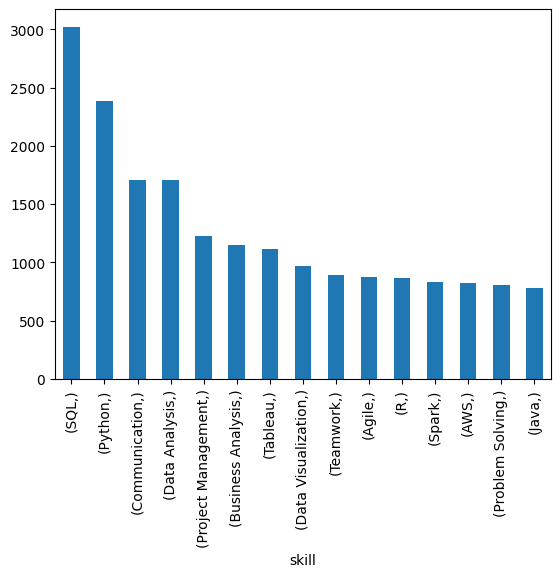

In [28]:
counting[:15].plot.bar()

## BMA

#### Data transformation into baskets and items

In [29]:
skills = data.select('skill') # don't need links
rdd = skills.rdd # insert data in spark
rdd = rdd.map(lambda x: x['skill']) # transformation
rdd.take(1)

["Business Analyst, DoD financial management processes, Government financial and accounting systems, Acquisition and budgeting processes, Relational databases, Financial and technical consulting, Government finance expertise, Financial data structuring, Reconciliation between systems, Financial forecasts and accounting data review, Government financial office support, Cost and Requirement System (CCaR™) experience, Bachelor's degree in business management engineering computer science mathematics economics, 7+ years of government acquisition finance financial management program management or related experience, 10+ years of equivalent technical training or work/military experience, Extended periods of sitting typing hearing seeing and speaking, Prolonged computer work and typing, Accurate communication, 15 lbs lifting/carrying, Office mobility, Federal background investigation, Travel, Varying work schedule, Additional hours and weekend work, $80000  $120000 annual salary, Employerpaid 

* yes, it's dirty, but...

In [30]:
baskets = rdd.map(lambda line: line.split(', ')) # 1 description = 1 basket with all skills as items
baskets.take(1) # 1 element = list from the baskets

[['Business Analyst',
  'DoD financial management processes',
  'Government financial and accounting systems',
  'Acquisition and budgeting processes',
  'Relational databases',
  'Financial and technical consulting',
  'Government finance expertise',
  'Financial data structuring',
  'Reconciliation between systems',
  'Financial forecasts and accounting data review',
  'Government financial office support',
  'Cost and Requirement System (CCaR™) experience',
  "Bachelor's degree in business management engineering computer science mathematics economics",
  '7+ years of government acquisition finance financial management program management or related experience',
  '10+ years of equivalent technical training or work/military experience',
  'Extended periods of sitting typing hearing seeing and speaking',
  'Prolonged computer work and typing',
  'Accurate communication',
  '15 lbs lifting/carrying',
  'Office mobility',
  'Federal background investigation',
  'Travel',
  'Varying work 

### Baskets' EDA

In [ ]:
lenghts = baskets.map(lambda x: len(x))
print(f"Max number of items in the basket is: {lenghts.max()}\n")
print(f"The average number of items in the basket is: {lenghts.mean()}\n")
print(f"The total number of baskets is: {baskets.count()}\n")
print(f"The approximate total number of items is:{round(lenghts.mean() * baskets.count())}")

Max number of items in the basket is: 224

The average number of items in the basket is: 26.54598969830757

The total number of baskets is: 6795

The approximate total number of items is:180380


In [55]:
def support(basket, percentsge):
  support = round(basket.count() * 0.01)
  return support

In [61]:
supp = support(baskets, 0.01)

### HashTable

In [71]:
hash = baskets.flatMap(lambda line: line) \
              .distinct()
              #flat the results into a single RDD
hash.take(5)

['Test cases',
 'Test data preparation',
 'Project status communication',
 'Airflow',
 'Mentoring']

In [ ]:
hash.count()

41020

In [65]:
hash_index = hash.zipWithIndex() \
                  .collectAsMap()

In [66]:
def hashing(basket):
    return {hash_index[skill] for skill in basket}

hashed_baskets = baskets.map(hashing)
hashed_baskets.take(1)

[{406,
  2240,
  2456,
  4099,
  6756,
  7168,
  7376,
  7764,
  9033,
  13664,
  13873,
  16413,
  16414,
  16614,
  19043,
  19693,
  20314,
  20923,
  22561,
  23187,
  23816,
  28149,
  29175,
  31035,
  32075,
  32937,
  32938,
  33317,
  36753,
  37372,
  38453,
  39282}]

### A-PRIORY

In [74]:
def first_pass(baskets, hash_table):

    '''Do the first pass of algo = count occurencies of each item'''

    frst_pass = baskets.flatMap(lambda basket: [(skill, 1) for skill in basket]) \
                        .reduceByKey(lambda x,y: x+y) \
                        .filter(lambda x: x[1]>supp)

    '''Check that it works  = due to support threshold we have frequent items (skills)'''
    try:
      frst_pass_count = frst_pass.count()
      if frst_pass_count == 0:
        raise ValueError('There are no frequent items')
    except ValueError as e:
      print('Low your support')
      print(e)
      return

    print(f"The number of frequent singletons is: {frst_pass_count}")

    '''Ask to see the most frequent items (skill)'''

    freq_items_idx = frst_pass.max(lambda x: x[1])
    freq_items = (list(hash_table.keys())[list(hash_table.values()).index(freq_items_idx[0])])
    print(f"The most frequent singleton:{freq_items}")

In [75]:
first_pass(hashed_baskets, hash_index)

The number of frequent singletons is: 352
The most frequent singleton:SQL


###### Новый code

In [ ]:
from itertools import combinations

In [ ]:
class Apriory:
  def __init__(self, baskets, support, hash_table):
    self.baskets = baskets
    self.support = support
    self.hash_table = hash_table

  def first_pass(self):

    '''Do the first pass of algo = count occurencies of each item'''

    frst_pass = self.baskets.flatMap(lambda basket: [(skill,1) for skill in basket]) \
                        .reduceByKey(lambda x,y: x+y) \
                        .filter(lambda x: x[1]>self.support)

    '''Check that it works  = due to support threshold we have frequent items (skills)'''
    try:
      frst_pass_count = frst_pass.count()
      if frst_pass_count == 0:
        raise ValueError('There are no frequent items')
    except ValueError as e:
      print('Low your support')
      print(e)
      return

    print(f"The number of frequent singletons is: {frst_pass_count}")

    '''Ask to see the most frequent item (skill)'''

    freq_sngltn_idx = frst_pass.max(lambda x: x[1])
    freq_sngltn = (list(self.hash_table.keys())[list(self.hash_table.values()).index(freq_sngltn_idx[0])])
    print(f"The most frequent singleton:{freq_sngltn}")

  def second_pass(self):
      # Collect frequent singletons on driver
      frequent_singletons = set(self.first_pass.map(lambda x: (x[0],)).collect())
      k = 2
      while True:
        print(f"The basket size is: {k}")

        candidate_itemsets = self.baskets.flatMap(lambda basket:[(skill,1) for skill in combinations(sorted(basket),k) if all(item in frequent_singletons for item in combinations(skill,k-1))])
        scnd_pass = candidate_itemsets.reduceByKey(lambda x,y: x+y)
        scnd_pass_count = scnd_pass.count()  # Call count outside flatMap

        if scnd_pass_count != 0:
          # Rest of your code for processing frequent itemsets
          frequencies = set(scnd_pass.map(lambda x: x[0]).collect())
          k += 1
        else:
          print(f"There is no frequent {k}-plets itemsets")
          return
          break

In [52]:
# from itertools import combinations

# class Apriori:
#     def __init__(self, baskets):
#         self.baskets = baskets

#     def data_transform(self, percentage):
#         '''calculate support'''
#         self.percentage = percentage
#         self.support = round(self.baskets.count() * self.percentage)
#         print(f"Support is {self.support}")

#         '''create hash table'''
#         item = self.baskets.flatMap(lambda line: line).distinct()
#         item_index = item.zipWithIndex().collectAsMap()
#         hashed_baskets = [set(item_index[skill] for skill in basket) for basket in self.baskets.collect()]
#         return item.take(5), item.count(1), hashed_baskets

#     def first_pass(self):
#         '''Do the first pass of algo = count occurrences of each item'''
#         frst_pass = self.baskets.flatMap(lambda basket: [(skill, 1) for skill in basket]) \
#                                 .reduceByKey(lambda x, y: x + y) \
#                                 .filter(lambda x: x[1] > self.support)

#         '''Check that it works  = due to support threshold we have frequent items (skills)'''
#         try:
#             frst_pass_count = frst_pass.count()
#             if frst_pass_count == 0:
#                 raise ValueError('There are no frequent items')
#         except ValueError as e:
#             print('Lower your support')
#             print(e)
#             return None

#         print(f"The number of frequent singletons is: {frst_pass_count}")

#         '''Ask to see the most frequent item (skill)'''
#         freq_sngltn_idx = frst_pass.max(lambda x: x[1])
#         item_index = self.data_transform(self.percentage)[1]
#         freq_sngltn = list(item_index.keys())[list(item_index.values()).index(freq_sngltn_idx[0])]
#         print(f"The most frequent singleton: {freq_sngltn}")

#         return frst_pass

#     def second_pass(self):
#         first_pass_result = self.first_pass()
#         if first_pass_result is None:
#             return

#         frequent_singletons = set(first_pass_result.map(lambda x: x[0]).collect())
#         k = 2
#         print(f"The basket size is: {k}")

#         candidate_itemsets = self.baskets.flatMap(
#             lambda basket: [
#                 (tuple(skill), 1) for skill in combinations(sorted(basket), k)
#                 if all(item in frequent_singletons for item in combinations(skill, k - 1))
#             ]
#         )
#         scnd_pass = candidate_itemsets.reduceByKey(lambda x, y: x + y)
#         scnd_pass_count = scnd_pass.count()

#         if scnd_pass_count != 0:
#             frequent_pairs = scnd_pass.filter(lambda x: x[1] > self.support).collect()
#             print(f"Frequent pairs: {frequent_pairs}")
#         else:
#             print(f"There are no frequent {k}-plets itemsets")


In [53]:
trial = Apriori(baskets=baskets)

In [50]:
trial.data_transform(0.01)

Support is 68


(['Test cases',
  'Test data preparation',
  'Project status communication',
  'Airflow',
  'Mentoring'],
 41020,
 [{406,
   2240,
   2456,
   4099,
   6756,
   7168,
   7376,
   7764,
   9033,
   13664,
   13873,
   16413,
   16414,
   16614,
   19043,
   19693,
   20314,
   20923,
   22561,
   23187,
   23816,
   28149,
   29175,
   31035,
   32075,
   32937,
   32938,
   33317,
   36753,
   37372,
   38453,
   39282},
  {1206,
   2241,
   3251,
   3886,
   4100,
   7994,
   9220,
   16415,
   24412,
   25224,
   30225,
   35331},
  {1022,
   1621,
   3668,
   4725,
   7765,
   10848,
   11071,
   15332,
   16808,
   20527,
   21336,
   21752,
   23188,
   25819,
   27360,
   33129,
   38454},
  {5147,
   15332,
   17018,
   19246,
   21550,
   27738,
   30636,
   30833,
   34279,
   35331,
   38455,
   38666,
   38667},
  {199,
   3251,
   6757,
   8408,
   11288,
   14492,
   15144,
   15994,
   17019,
   17864,
   18235,
   19044,
   21753,
   22562,
   22563,
   23374,
   25630,


In [54]:
trial.first_pass()

Traceback (most recent call last):
  File "/content/spark-3.1.1-bin-hadoop3.2/python/pyspark/serializers.py", line 437, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
  File "/content/spark-3.1.1-bin-hadoop3.2/python/pyspark/cloudpickle/cloudpickle_fast.py", line 72, in dumps
    cp.dump(obj)
  File "/content/spark-3.1.1-bin-hadoop3.2/python/pyspark/cloudpickle/cloudpickle_fast.py", line 540, in dump
    return Pickler.dump(self, obj)
  File "/content/spark-3.1.1-bin-hadoop3.2/python/pyspark/rdd.py", line 263, in __getnewargs__
    raise Exception(
Exception: It appears that you are attempting to broadcast an RDD or reference an RDD from an action or transformation. RDD transformations and actions can only be invoked by the driver, not inside of other transformations; for example, rdd1.map(lambda x: rdd2.values.count() * x) is invalid because the values transformation and count action cannot be performed inside of the rdd1.map transformation. For more information, see SPAR

PicklingError: Could not serialize object: Exception: It appears that you are attempting to broadcast an RDD or reference an RDD from an action or transformation. RDD transformations and actions can only be invoked by the driver, not inside of other transformations; for example, rdd1.map(lambda x: rdd2.values.count() * x) is invalid because the values transformation and count action cannot be performed inside of the rdd1.map transformation. For more information, see SPARK-5063.

##### The first pass (count occurencies of each item)

In [70]:
first_pass = hashed_baskets.flatMap(lambda basket:[(e,1) for e in basket]) \
                .reduceByKey(lambda x,y:x+y) \
                .filter(lambda x:x[1]>supp)

print("remaining singleton", first_pass.count())
print("5 random singleton", first_pass.take(5))

remaining singleton 352
5 random singleton [(30000, 84), (201, 628), (3, 272), (16003, 73), (4, 152)]


In [ ]:
# to count all pair composed of frequent singletons
from itertools import combinations

frequent_singletons = set(first_pass.map(lambda x:x[0]).collect())
second_pass = hashed_baskets.flatMap(lambda basket:[(e,1) for e in combinations(sorted(basket),2)]) \
                 .filter(lambda x: x[0][0] in frequent_singletons) \
                 .filter(lambda x: x[0][1] in frequent_singletons) \
                 .reduceByKey(lambda x,y: x+y) \
                 .filter(lambda x:x[1]>s)

print(second_pass.count())

In [ ]:
frdd = hashed_baskets.flatMap(lambda basket:[(e,1) for e in basket]) \
          .reduceByKey(lambda x,y:x+y) \
          .filter(lambda x:x[1] > s)

frequent = set(first_pass.map(lambda x:(x[0],)).collect())

print(f"remaining: {len(frequent)}, frdd {frdd.take(5)}")

k = 2
while frdd.count() != 0:
    frdd = hashed_baskets.flatMap(lambda basket: [(x,1) for x in combinations(sorted(basket),k)])\
              .filter(lambda x: all([y in frequent for y in combinations(x[0],len(x[0])-1)])) \
              .reduceByKey(lambda x,y:x+y) \
              .filter(lambda x:x[1] > s)

    frequent = set(frdd.map(lambda x:x[0]).collect())
    print(k, len(frequent), frdd.take(5))
    k += 1